# PyTorch paper replication for Vision transformer

Turn the research paper into usable code.

### Get setup

Import already written code and libraries.

In [2]:
import os
print(os.getcwd())

D:\python_projects\Gym\pytorch


In [3]:
import torch
import torchvision

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

PyTorch version: 2.7.1+cu126
Torchvision version: 0.22.1+cpu


In [4]:
import torchinfo


from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

D:\python_projects\Gym\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### Get data

Replicate the ViT architecture for FoodVisionMini.

In [6]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [8]:
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## Create datasets and dataloaders

In [9]:
from going_modular import data_setup
from torchvision import transforms

# Create image size
IMAGE_SIZE = 224  # ViT paper uses 224x224 images

#Create data transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to tensors
])
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [10]:
BATCH_SIZE = 32

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x244b4e81450>,
 ['pizza', 'steak', 'sushi'])

In [11]:
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### Visualize a single image and its label



In [12]:
# Get a batch of images and labels
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label
image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

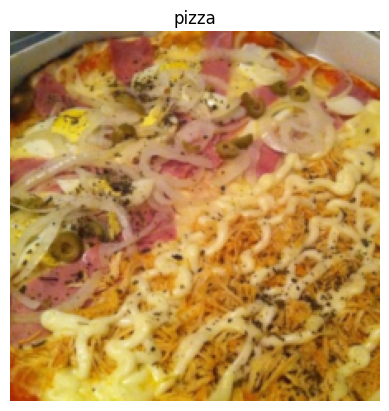

In [13]:
# PLot the image with matplotlib
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))  # Permute to (H, W, C) for plotting
plt.title(class_names[label])
plt.axis("off")

### Replicate ViT architecture: Overview

### Equation 1: Split data into patches and creating the class, position and patch embeddings

Layer = input -> function -> output

* Input shape = (224, 224, 3)
* Output shape = ()

In [14]:
# Create example values

height = 224
width = 224
color_channels = 3
patch_size = 16

# Number of patches
number_of_patches = (height // patch_size) * (width // patch_size)
number_of_patches

196

In [15]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)
# Output shape
embedding_layer_output_shape = (number_of_patches, color_channels * patch_size**2)

embedding_layer_input_shape, embedding_layer_output_shape

((224, 224, 3), (196, 768))

### Turn a single image into patches.

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

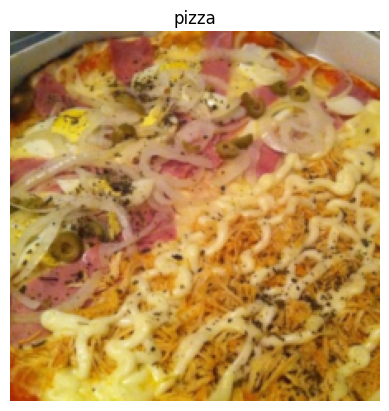

In [16]:
# View a single image
plt.imshow(image.permute(1, 2, 0))  # Permute to (H, W, C) for plotting
plt.title(class_names[label])
plt.axis("off")

In [17]:
image.shape

torch.Size([3, 224, 224])

Text(0.5, 1.0, 'Top-row of the image')

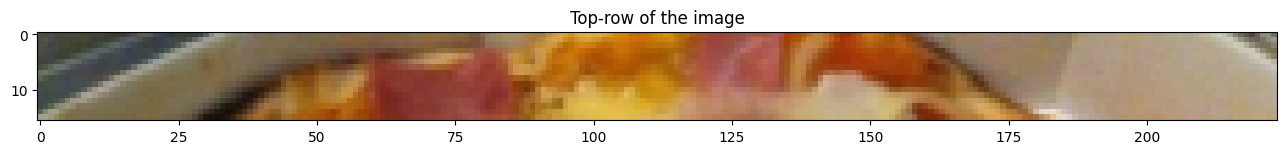

In [18]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0)  # Change shape to (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])  # Plot the top-left patch
plt.title("Top-row of the image")

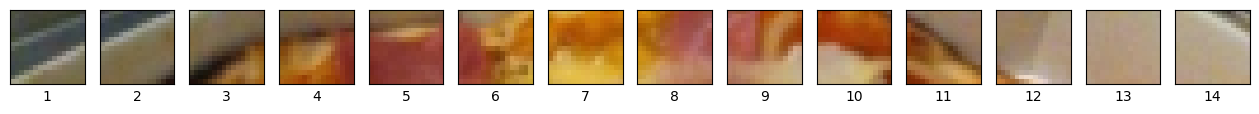

In [19]:
# Setup code to plot top row as patches

img_size = 224
patch_size = 16
number_of_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size."

# Create a series of subplots to visualize patches
fig, axes = plt.subplots(nrows=1, 
                         ncols=int(number_of_patches),
                         sharex=True,
                         sharey=True,
                         figsize=(patch_size, patch_size))


for i, patch in enumerate(range(0, img_size, patch_size)):
    axes[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axes[i].set_xlabel(i+1)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

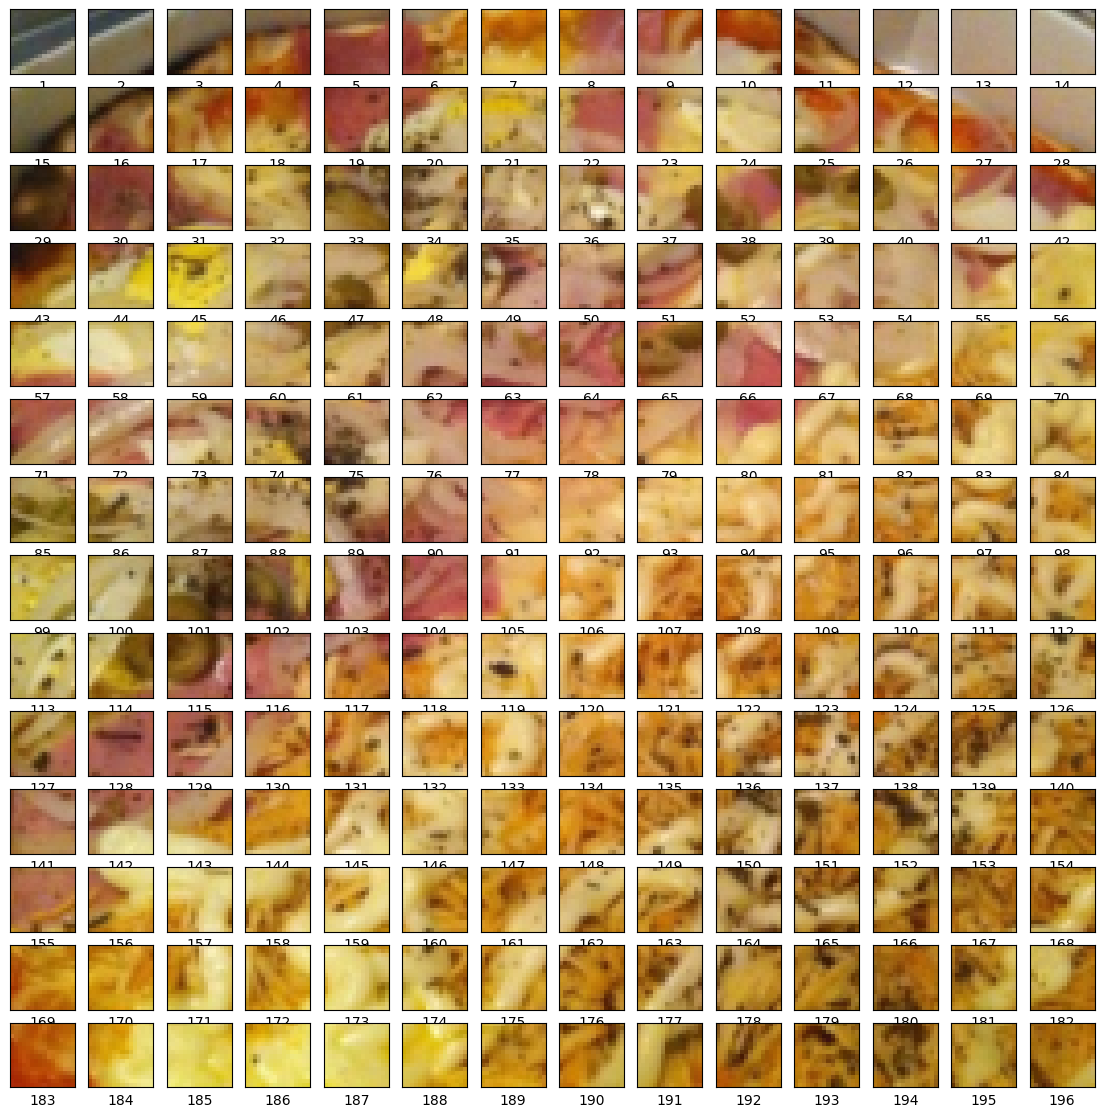

In [20]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
number_of_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size."

# Create a series of subplots to visualize patches
fig, axes = plt.subplots(
    nrows=int(number_of_patches),
    ncols=int(number_of_patches),
    figsize=(number_of_patches, number_of_patches),
    sharex=True,
    sharey=True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axes[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                         patch_width:patch_width+patch_size, :])
        axes[i, j].set_xlabel(f"{i * int(number_of_patches) + j + 1}")
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
                         

### Creating image patches and transforming them into embeddings.

In [21]:
# Create conv2d layer to turn an image into patches
from torch import nn

# Set the patch size
patch_size = 16

# Create a convolutional layer to extract patches
conv2d = nn.Conv2d(
    in_channels=3,  # Number of color channels in the image
    out_channels=3 * patch_size**2,  # Each patch will have 3 * patch_size^2 features
    kernel_size=patch_size,  # Patch size
    stride=patch_size,  # Move by patch size to get non-overlapping patches
    padding=0,  # No padding needed for non-overlapping patches
)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

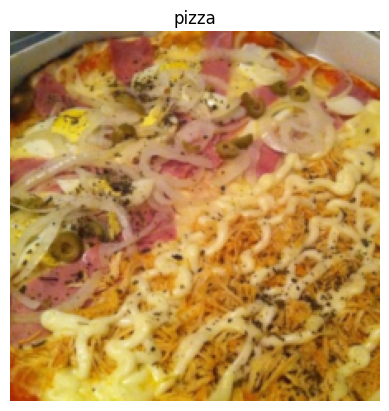

In [22]:
# View single image
plt.imshow(image.permute(1, 2, 0))  # Permute to (H, W, C) for plotting
plt.title(class_names[label])
plt.axis("off")

In [23]:
# Pass the image through the conv2d layer
image_out_of_conv = conv2d(image.unsqueeze(0))  # Add batch dimension
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [24]:
flatten = image_out_of_conv.flatten(2,3)
flatten.shape  # Flatten the output to (batch_size, num_patches, patch_features)

torch.Size([1, 768, 196])

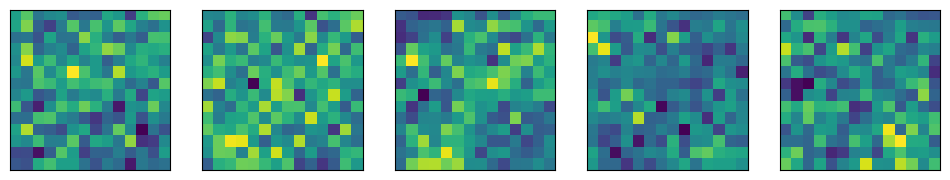

In [25]:
import random
random_indexes = random.sample(range(0, 768), k=5)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, index in enumerate(random_indexes):
    image_conv_map = image_out_of_conv[0, index, :, :]
    axes[i].imshow(image_conv_map.squeeze().detach().numpy())
    axes[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

### Flatten the embeddings using torch.nn.Flatten.

In [26]:
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [27]:
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)

flatten_layer(image_out_of_conv).shape  # Flatten the output to (batch_size, num_patches, patch_features)

torch.Size([1, 768, 196])

Image shape: torch.Size([3, 224, 224])
Image out of conv shape: torch.Size([1, 768, 14, 14])
Image out of conv flattened shape: torch.Size([1, 768, 196])


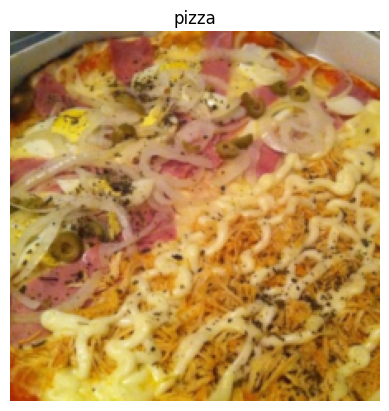

In [28]:
# Put everything together

plt.imshow(image.permute(1, 2, 0))  # Permute to (H, W, C) for plotting
plt.title(class_names[label])
plt.axis("off")
print(f"Image shape: {image.shape}")

# Turn the image into patches
image_out_of_conv = conv2d(image.unsqueeze(0))  # Add batch dimension
print(f"Image out of conv shape: {image_out_of_conv.shape}")

# Flatten the output
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Image out of conv flattened shape: {image_out_of_conv_flattened.shape}")

In [29]:
# Rearrange the output of flatten layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)  # (batch_size, num_patches, patch_features)
print(f"Image out of conv flattened rearranged shape: {image_out_of_conv_flattened_permuted.shape}")

Image out of conv flattened rearranged shape: torch.Size([1, 196, 768])


Single flattened feature map shape: torch.Size([1, 196])


(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

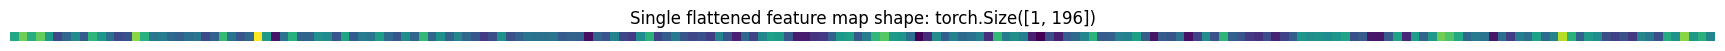

In [30]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

print(f"Single flattened feature map shape: {single_flattened_feature_map.shape}")

#Plot the single flattened feature map visualization
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Single flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis("off")

### Turning the ViT patch embedding layer into a PyTorch module

In [31]:
class PatchEmbedding(nn.Module):
    def __init__(self, 
                 in_channels:int=3, 
                 patch_size:int=16, 
                 embedding_dim:int=768):
        super().__init__()

        self.patch_size = patch_size  # Size of each patch
        
        self.patcher = nn.Conv2d(
            in_channels=in_channels,  # Number of color channels in the image
            out_channels=embedding_dim,  # Each patch will have embedding_dim features
            kernel_size=patch_size,  # Patch size
            stride=patch_size,  # Move by patch size to get non-overlapping patches
            padding=0)  # No padding needed for non-overlapping patches
        
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the patch embedding layer.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_channels, height, width).
        
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_patches, embedding_dim).
        """
        image_resolution = x.shape[-1] 
        assert image_resolution % patch_size == 0, f"Image resolution {image_resolution} must be divisible by patch size {self.patch_size}."

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        x_permuted = x_flattened.permute(0, 2, 1)

        return x_permuted  # Return shape (batch_size, num_patches, embedding_dim)


In [32]:
set_seeds()

# Create a patch embedding layer
patchify = PatchEmbedding(
    in_channels=3,  # Number of color channels in the image
    patch_size=16,  # Patch size
    embedding_dim=768  # Embedding dimension
)

# Pass a single image through the patch embedding layer
print(f"Image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))  # Add batch dimension
print(f"Patch embedded image shape: {patch_embedded_image.shape}")

Image shape: torch.Size([1, 3, 224, 224])
Patch embedded image shape: torch.Size([1, 196, 768])


In [33]:
rand_image_tensor = torch.randn(1, 3, 224, 224)  # Random image tensor with shape (batch_size, in_channels, height, width)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)  # Random image tensor with shape (batch_size, in_channels, height, width)

# patchify(rand_image_tensor_bad)  # Should work


### Creating the class token embedding

In [34]:
patch_embedded_image.shape  # Should be (1, 196, 768) for a 224x224 image with 16x16 patches

torch.Size([1, 196, 768])

In [35]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[-1]
print(f"Batch size: {batch_size}, Embedding dimension: {embedding_dim}")

Batch size: 1, Embedding dimension: 768


In [36]:
#Create class token embedding as a learnable parameter that share same shape as the patch embeddings
class_token = nn.Parameter(
    torch.ones(batch_size, 1, embedding_dim),
    requires_grad=True)

class_token.shape  # Should be (1, 1, 768) for a batch size of 1 and embedding dimension of 768

torch.Size([1, 1, 768])

In [37]:
# Add the class token to the patch embedded image front
patch_embedded_image_with_class_embedding = torch.cat(
    (class_token, patch_embedded_image), 
    dim=1)  # Concatenate along the sequence dimension

print(patch_embedded_image_with_class_embedding)  # Should be (1, 197, 768) for a batch size of 1, 196 patches and 1 class token
print(f"Patch embedded image with class embedding shape: {patch_embedded_image_with_class_embedding.shape}")


tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.2822,  0.0788, -0.1979,  ...,  0.3563, -0.1261,  0.1565],
         [-0.4704,  0.1913, -0.0641,  ...,  0.2953, -0.2542,  0.2238],
         ...,
         [-0.3596,  0.0778, -0.1163,  ...,  0.2634, -0.3222,  0.2008],
         [-0.5836,  0.0583, -0.1942,  ...,  0.3501, -0.2689,  0.2586],
         [-0.5488,  0.1195, -0.0725,  ...,  0.3743, -0.2607,  0.1262]]],
       grad_fn=<CatBackward0>)
Patch embedded image with class embedding shape: torch.Size([1, 197, 768])


### Creating the positional embeddings

Want to: create a 1d learnable positional embeddings and add them to the patch embeddings.

In [38]:
# View the sequence of patch embeddings with the prepended class token
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.2822,  0.0788, -0.1979,  ...,  0.3563, -0.1261,  0.1565],
          [-0.4704,  0.1913, -0.0641,  ...,  0.2953, -0.2542,  0.2238],
          ...,
          [-0.3596,  0.0778, -0.1163,  ...,  0.2634, -0.3222,  0.2008],
          [-0.5836,  0.0583, -0.1942,  ...,  0.3501, -0.2689,  0.2586],
          [-0.5488,  0.1195, -0.0725,  ...,  0.3743, -0.2607,  0.1262]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [40]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

positional_embedding = nn.Parameter(
    torch.ones(1, number_of_patches + 1, embedding_dimension),
    requires_grad=True)

positional_embedding, positional_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [41]:
# Add the positional embedding to the patch embedded image with class embedding
patch_and_positional_embedding = patch_embedded_image_with_class_embedding + positional_embedding
print(patch_and_positional_embedding)
print(f"Patch and positional embedding shape: {patch_and_positional_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.7178, 1.0788, 0.8021,  ..., 1.3563, 0.8739, 1.1565],
         [0.5296, 1.1913, 0.9359,  ..., 1.2953, 0.7458, 1.2238],
         ...,
         [0.6404, 1.0778, 0.8837,  ..., 1.2634, 0.6778, 1.2008],
         [0.4164, 1.0583, 0.8058,  ..., 1.3501, 0.7311, 1.2586],
         [0.4512, 1.1195, 0.9275,  ..., 1.3743, 0.7393, 1.1262]]],
       grad_fn=<AddBackward0>)
Patch and positional embedding shape: torch.Size([1, 197, 768])


### Putting it all together: from image to embedding.

In [58]:
# Set the seed
set_seeds(42)

# Set the patch size
patch_size = 16

# Print shapes of the original image and get the image dimensions
print(f"Original image shape: {image.shape}")
color_channels, height, width = image.shape
print(f"Image height: {height}")
print(f"Image width: {width}")
print(f"Image color channels: {color_channels}")

# Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Image tensor with batch dimension: {x.shape}")

# Create a patch embedding layer
patch_embedding_layer = PatchEmbedding(
    in_channels=color_channels,
    patch_size=patch_size,
    embedding_dim=768
)

# Pass the image through the patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedded image shape: {patch_embedding.shape}")


# Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dim = patch_embedding.shape[-1]

# Create a class token embedding as a learnable parameter that share same shape as the patch embeddings
class_token = nn.Parameter(
    torch.ones(batch_size, 1, embedding_dim),
    requires_grad=True
)
print(f"Class token embedding shape: {class_token.shape}")

# Add the class token to the patch embedded image
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# Create a learnable positional embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(
    torch.ones(1, number_of_patches + 1, embedding_dim),
    requires_grad=True
)
print(f"Position embedding shape: {position_embedding.shape}")

# Add the positional embedding to the patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch embedding with class token and positional embedding shape: {patch_and_position_embedding.shape}")

Original image shape: torch.Size([3, 224, 224])
Image height: 224
Image width: 224
Image color channels: 3
Image tensor with batch dimension: torch.Size([1, 3, 224, 224])
Patch embedded image shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Position embedding shape: torch.Size([1, 197, 768])
Patch embedding with class token and positional embedding shape: torch.Size([1, 197, 768])
